In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report, log_loss
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import re
from sqlalchemy import create_engine
from imblearn.under_sampling import RandomUnderSampler
import random

# Set random seed
random.seed(42)
np.random.seed(42)

# Database connection setup
db_config = {
    'host': 'localhost',
    'database': 'postgres',
    'user': 'postgres',
    'password': 'kaviyam123',
    'port': '5432'
}

connection_string = f"postgresql://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}"
engine = create_engine(connection_string)

query = 'SELECT * FROM public.overall_cleaned_base_and_pr_ef_policyef;'
data = pd.read_sql(query, con=engine)

selected_columns = ['policy no', 'renewal type', 'product name', 'product name 2',  'biztype', 'policy end date', 'policy start date', 
 'age', 'manufacturer/make', 'model', 'variant', 'vehicle segment', 'fuel type', 'rto location', 'vehicle idv', 'ncb amount', 'Cleaned Reg no', 
 'before gst add-on gwp', 'total od premium', 'total tp premium', 'gst', 'total premium payable', 
 'ncb % previous year', 'applicable discount with ncb', 'Cleaned Branch Name 2', 'Cleaned State2', 'Cleaned Zone 2', 'tie up',
 'Number of claims', 'approved', 'denied', 'corrected_name', 'customerid', 'Policy Status', 'Policy Tenure', 'Customer Tenure', 'New Customers', 'Claim Happaned/Not', 
 'Renewal Rate Status', 'withdrawn', 'chassis_engine_key', 'policy_wise_purchase']

data = data[selected_columns]

# Remove rows where 'Status' contains 'Open'
data = data[data['Policy Status'].isin(['Renewed', 'Not Renewed'])]


data['Policy Status'] = data['Policy Status'].apply(lambda x: 1 if x == 'Not Renewed' else 0)

for column in data.columns:
    if data[column].dtype == 'object':
        data[column] = data[column].fillna('missing')
    else:
        data[column] = data[column].fillna(0)

date_columns = ['policy start date', 'policy end date']

for col in date_columns:
    data[col] = pd.to_datetime(data[col], errors='coerce')

# Extract year, month, and day as separate features for all date columns
new_date_cols = {}
for col in date_columns:
    new_date_cols[f'{col}_YEAR'] = data[col].dt.year
    new_date_cols[f'{col}_MONTH'] = data[col].dt.month
    new_date_cols[f'{col}_DAY'] = data[col].dt.day

data = pd.concat([data, pd.DataFrame(new_date_cols)], axis=1)

# Drop date columns after splitting
data = data.drop(columns=date_columns)

# Define features and target
features = [col for col in data.columns if col not in ['Policy Status']]

# Define X (features) and y (target)
X = data[features]
y = data['Policy Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [2]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, log_loss, roc_curve
import matplotlib.pyplot as plt

# Initialize RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Apply Random Oversampling to the training data
X_train, y_train = ros.fit_resample(X_train, y_train)

In [3]:
# Apply label encoding to categorical features for both train and test sets
for column in X_train.columns:
    if X_train[column].dtype == 'object':
        # Initialize and fit the LabelEncoder on the training data
        label_encoder = LabelEncoder()
        X_train[column] = label_encoder.fit_transform(X_train[column].astype(str))

        # Create a mapping dictionary from the LabelEncoder
        mapping_dict = {label: i for i, label in enumerate(label_encoder.classes_)}
        
        # Track the next unique integer for unseen values in the test set
        next_unique_value = [max(mapping_dict.values()) + 1]  

        # Encode the test data
        def encode_test_value(value):
            if value in mapping_dict:
                return mapping_dict[value]
            else:
                # Update the mapping_dict with a new unique value for unseen categories
                mapping_dict[value] = next_unique_value[0]
                next_unique_value[0] += 1
                return mapping_dict[value]

        # Apply the encoding to the test set
        X_test[column] = X_test[column].apply(encode_test_value)

Test Accuracy: 0.7436
Test Log Loss: 0.5251
Test ROC AUC: 0.8093
Test Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.64      0.65    111075
           1       0.79      0.80      0.80    189528

    accuracy                           0.74    300603
   macro avg       0.72      0.72      0.72    300603
weighted avg       0.74      0.74      0.74    300603

Class 0 Test Accuracy: 0.6424
Class 1 Test Accuracy: 0.8029

Train Accuracy: 0.7503
Train Log Loss: 0.5177
Train ROC AUC: 0.8291
Train Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.79      0.76    758110
           1       0.77      0.71      0.74    758110

    accuracy                           0.75   1516220
   macro avg       0.75      0.75      0.75   1516220
weighted avg       0.75      0.75      0.75   1516220

Class 0 Train Accuracy: 0.7944
Class 1 Train Accuracy: 0.7061



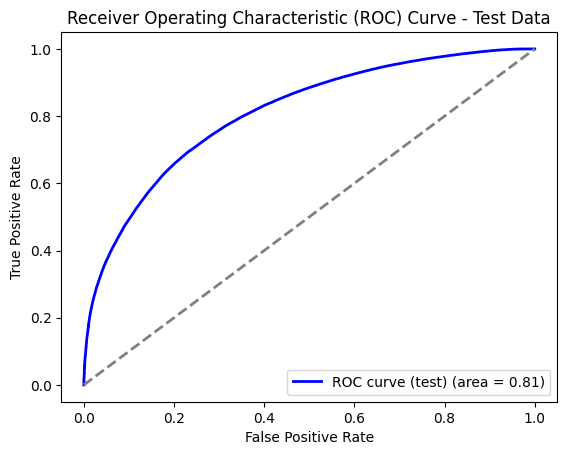

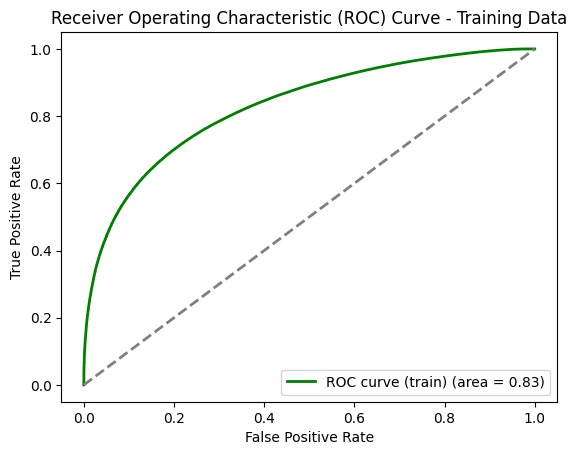

In [4]:
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, classification_report, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

# Define the models
from sklearn.ensemble import RandomForestClassifier
model_1 = RandomForestClassifier(random_state=42, max_depth=10)

model_2 = CatBoostClassifier(
    depth=10, learning_rate=0.1, iterations=500, 
    random_seed=42, verbose=0)

model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)

# Get probability predictions from both models
probs_1_test = model_1.predict_proba(X_test)
probs_2_test = model_2.predict_proba(X_test)

probs_1_train = model_1.predict_proba(X_train)
probs_2_train = model_2.predict_proba(X_train)

# Define model weights
weight_1 = 0.45  # Model 1 works well for class 0
weight_2 = 0.55  # Model 2 works well for class 1

# Compute weighted average of probabilities
weighted_probs_test = (weight_1 * probs_1_test) + (weight_2 * probs_2_test)
weighted_probs_train = (weight_1 * probs_1_train) + (weight_2 * probs_2_train)

# Apply argmax to get final class predictions
y_pred = np.argmax(weighted_probs_test, axis=1)
y_pred_proba = weighted_probs_test[:, 1]

y_train_pred = np.argmax(weighted_probs_train, axis=1)
y_train_pred_proba = weighted_probs_train[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Log Loss: {log_loss_value:.4f}")
print(f"Test ROC AUC: {roc_auc:.4f}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test:.4f}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test:.4f}\n")

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Train Log Loss: {train_log_loss:.4f}")
print(f"Train ROC AUC: {train_roc_auc:.4f}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train:.4f}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train:.4f}\n")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

----- TEST SET EVALUATIONS -----

--- Sens=Spec ---
Threshold: 0.5530
Accuracy: 0.7303 | ROC AUC: 0.8093 | Log Loss: 0.5251
Class 0 Accuracy: 0.7303 | Class 1 Accuracy: 0.7303
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.73      0.67    111075
           1       0.82      0.73      0.77    189528

    accuracy                           0.73    300603
   macro avg       0.72      0.73      0.72    300603
weighted avg       0.75      0.73      0.73    300603

--- MaxSens+Spec ---
Threshold: 0.5762
Accuracy: 0.7218 | ROC AUC: 0.8093 | Log Loss: 0.5251
Class 0 Accuracy: 0.7667 | Class 1 Accuracy: 0.6955
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.77      0.67    111075
           1       0.84      0.70      0.76    189528

    accuracy                           0.72    300603
   macro avg       0.72      0.73      0.71    300603
weighted avg       0.75      0.72 

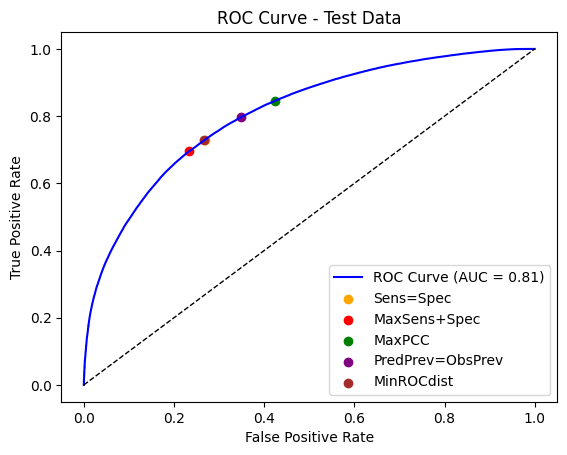

KeyboardInterrupt: 

In [5]:
from sklearn.metrics import (
    accuracy_score, log_loss, roc_auc_score, 
    classification_report, confusion_matrix, roc_curve
)
import matplotlib.pyplot as plt
import numpy as np

# ----- ROC for Test -----
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_proba)
spec_test = 1 - fpr_test
obs_pos_rate_test = np.mean(y_test)

# Sens = Spec
diff_sens_spec = np.abs(tpr_test - spec_test)
idx_sens_spec = np.argmin(diff_sens_spec)
thresh_sens_spec = thresholds_test[idx_sens_spec]

# Max Sens + Spec (Youden’s J)
youden_test = tpr_test - fpr_test
idx_youden = np.argmax(youden_test)
thresh_youden = thresholds_test[idx_youden]

# MaxPCC
accuracies_test = [(accuracy_score(y_test, (y_pred_proba >= t).astype(int))) for t in thresholds_test]
idx_maxpcc = np.argmax(accuracies_test)
thresh_maxpcc = thresholds_test[idx_maxpcc]

# PredPrev = ObsPrev
pred_pos_rates_test = [np.mean(y_pred_proba >= t) for t in thresholds_test]
diff_pred_prev = np.abs(np.array(pred_pos_rates_test) - obs_pos_rate_test)
idx_predprev = np.argmin(diff_pred_prev)
thresh_predprev = thresholds_test[idx_predprev]

# MinROCdist
roc_dist_test = np.sqrt((1 - tpr_test)**2 + fpr_test**2)
idx_minrocdist = np.argmin(roc_dist_test)
thresh_minrocdist = thresholds_test[idx_minrocdist]

# Thresholds dict
thresholds_test_dict = {
    "Sens=Spec": thresh_sens_spec,
    "MaxSens+Spec": thresh_youden,
    "MaxPCC": thresh_maxpcc,
    "PredPrev=ObsPrev": thresh_predprev,
    "MinROCdist": thresh_minrocdist
}

# Evaluate each threshold type
print("----- TEST SET EVALUATIONS -----\n")
for name, thresh in thresholds_test_dict.items():
    preds = (y_pred_proba >= thresh).astype(int)
    acc = accuracy_score(y_test, preds)
    auc = roc_auc_score(y_test, y_pred_proba)
    loss = log_loss(y_test, y_pred_proba)
    report = classification_report(y_test, preds)
    conf = confusion_matrix(y_test, preds)
    class_0 = conf[0, 0] / conf[0].sum()
    class_1 = conf[1, 1] / conf[1].sum()

    print(f"--- {name} ---")
    print(f"Threshold: {thresh:.4f}")
    print(f"Accuracy: {acc:.4f} | ROC AUC: {auc:.4f} | Log Loss: {loss:.4f}")
    print(f"Class 0 Accuracy: {class_0:.4f} | Class 1 Accuracy: {class_1:.4f}")
    print(f"Classification Report:\n{report}")

# ROC plot with threshold points
plt.figure()
plt.plot(fpr_test, tpr_test, label=f'ROC Curve (AUC = {auc:.2f})', color='blue')
plt.scatter(fpr_test[idx_sens_spec], tpr_test[idx_sens_spec], color='orange', label='Sens=Spec')
plt.scatter(fpr_test[idx_youden], tpr_test[idx_youden], color='red', label='MaxSens+Spec')
plt.scatter(fpr_test[idx_maxpcc], tpr_test[idx_maxpcc], color='green', label='MaxPCC')
plt.scatter(fpr_test[idx_predprev], tpr_test[idx_predprev], color='purple', label='PredPrev=ObsPrev')
plt.scatter(fpr_test[idx_minrocdist], tpr_test[idx_minrocdist], color='brown', label='MinROCdist')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.title("ROC Curve - Test Data")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# ----- ROC for Train -----
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_proba)
spec_train = 1 - fpr_train
obs_pos_rate_train = np.mean(y_train)

# Sens = Spec
diff_sens_spec_train = np.abs(tpr_train - spec_train)
idx_sens_spec_train = np.argmin(diff_sens_spec_train)
thresh_sens_spec_train = thresholds_train[idx_sens_spec_train]

# Max Sens + Spec
youden_train = tpr_train - fpr_train
idx_youden_train = np.argmax(youden_train)
thresh_youden_train = thresholds_train[idx_youden_train]

# MaxPCC
accuracies_train = [(accuracy_score(y_train, (y_train_pred_proba >= t).astype(int))) for t in thresholds_train]
idx_maxpcc_train = np.argmax(accuracies_train)
thresh_maxpcc_train = thresholds_train[idx_maxpcc_train]

# PredPrev = ObsPrev
pred_pos_rates_train = [np.mean(y_train_pred_proba >= t) for t in thresholds_train]
diff_pred_prev_train = np.abs(np.array(pred_pos_rates_train) - obs_pos_rate_train)
idx_predprev_train = np.argmin(diff_pred_prev_train)
thresh_predprev_train = thresholds_train[idx_predprev_train]

# MinROCdist
roc_dist_train = np.sqrt((1 - tpr_train)**2 + fpr_train**2)
idx_minrocdist_train = np.argmin(roc_dist_train)
thresh_minrocdist_train = thresholds_train[idx_minrocdist_train]

thresholds_train_dict = {
    "Sens=Spec": thresh_sens_spec_train,
    "MaxSens+Spec": thresh_youden_train,
    "MaxPCC": thresh_maxpcc_train,
    "PredPrev=ObsPrev": thresh_predprev_train,
    "MinROCdist": thresh_minrocdist_train
}

# Evaluate each threshold on train set
print("----- TRAIN SET EVALUATIONS -----\n")
for name, thresh in thresholds_train_dict.items():
    preds = (y_train_pred_proba >= thresh).astype(int)
    acc = accuracy_score(y_train, preds)
    auc = roc_auc_score(y_train, y_train_pred_proba)
    loss = log_loss(y_train, y_train_pred_proba)
    report = classification_report(y_train, preds)
    conf = confusion_matrix(y_train, preds)
    class_0 = conf[0, 0] / conf[0].sum()
    class_1 = conf[1, 1] / conf[1].sum()

    print(f"--- {name} ---")
    print(f"Threshold: {thresh:.4f}")
    print(f"Accuracy: {acc:.4f} | ROC AUC: {auc:.4f} | Log Loss: {loss:.4f}")
    print(f"Class 0 Accuracy: {class_0:.4f} | Class 1 Accuracy: {class_1:.4f}")
    print(f"Classification Report:\n{report}")

# ROC plot for training data
plt.figure()
plt.plot(fpr_train, tpr_train, label=f'ROC Curve (AUC = {auc:.2f})', color='green')
plt.scatter(fpr_train[idx_sens_spec_train], tpr_train[idx_sens_spec_train], color='orange', label='Sens=Spec')
plt.scatter(fpr_train[idx_youden_train], tpr_train[idx_youden_train], color='red', label='MaxSens+Spec')
plt.scatter(fpr_train[idx_maxpcc_train], tpr_train[idx_maxpcc_train], color='blue', label='MaxPCC')
plt.scatter(fpr_train[idx_predprev_train], tpr_train[idx_predprev_train], color='purple', label='PredPrev=ObsPrev')
plt.scatter(fpr_train[idx_minrocdist_train], tpr_train[idx_minrocdist_train], color='brown', label='MinROCdist')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.title("ROC Curve - Train Data")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [5]:
from sklearn.metrics import (
    accuracy_score, log_loss, roc_auc_score, 
    classification_report, confusion_matrix, roc_curve
)
import matplotlib.pyplot as plt
import numpy as np

# Recalibration Odds Setup (post-oversampling)
def recalibrate_probs(pred_probs, original_odds, train_odds):
    pred_probs = np.clip(pred_probs, 1e-6, 1 - 1e-6)
    scoring_odds = pred_probs / (1 - pred_probs)
    adjusted_odds = scoring_odds * (original_odds / train_odds)
    return adjusted_odds / (1 + adjusted_odds)

# Detect real-world churn rate (from original unbalanced dataset)
real_churn_rate = np.mean(y)   # from full dataset
train_churn_rate = np.mean(y_train)  # from oversampled training set

# Convert to odds
original_odds = real_churn_rate / (1 - real_churn_rate)
train_odds = train_churn_rate / (1 - train_churn_rate)

print(f"Real churn rate (original): {real_churn_rate:.4f}")
print(f"Train churn rate (oversampled): {train_churn_rate:.4f}")

Real churn rate (original): 0.6305
Train churn rate (oversampled): 0.5000


In [6]:
# --- Recalibrate test probabilities ---
y_pred_proba_recal = recalibrate_probs(y_pred_proba, original_odds, train_odds)

# --- Compute thresholds from ROC curve ---
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_proba)
spec_test = 1 - fpr_test
obs_pos_rate_test = np.mean(y_test)

idx_default = np.argmin(np.abs(thresholds_test - 0.5))
idx_sens_spec = np.argmin(np.abs(tpr_test - spec_test))
idx_youden = np.argmax(tpr_test - fpr_test)
idx_maxpcc = np.argmax([accuracy_score(y_test, (y_pred_proba >= t).astype(int)) for t in thresholds_test])
pred_pos_rates_test = [np.mean(y_pred_proba >= t) for t in thresholds_test]
idx_predprev = np.argmin(np.abs(np.array(pred_pos_rates_test) - obs_pos_rate_test))
roc_dist_test = np.sqrt((1 - tpr_test)**2 + fpr_test**2)
idx_minrocdist = np.argmin(roc_dist_test)

thresholds_test_dict = {
    "Default (0.5)": 0.5,
    "Sens=Spec": thresholds_test[idx_sens_spec],
    "MaxSens+Spec": thresholds_test[idx_youden],
    "MaxPCC": thresholds_test[idx_maxpcc],
    "PredPrev=ObsPrev": thresholds_test[idx_predprev],
    "MinROCdist": thresholds_test[idx_minrocdist]
}

# --- Evaluate each threshold on test set ---
print("\n----- TEST SET EVALUATION (BEFORE & AFTER RECALIBRATION) -----\n")
for name, thresh in thresholds_test_dict.items():
    preds_raw = (y_pred_proba >= thresh).astype(int)
    preds_recal = (y_pred_proba_recal >= thresh).astype(int)

    acc_raw = accuracy_score(y_test, preds_raw)
    auc_raw = roc_auc_score(y_test, y_pred_proba)
    loss_raw = log_loss(y_test, y_pred_proba)
    conf_raw = confusion_matrix(y_test, preds_raw)
    class_0_raw = conf_raw[0, 0] / conf_raw[0].sum()
    class_1_raw = conf_raw[1, 1] / conf_raw[1].sum()

    acc_recal = accuracy_score(y_test, preds_recal)
    auc_recal = roc_auc_score(y_test, y_pred_proba_recal)
    loss_recal = log_loss(y_test, y_pred_proba_recal)
    conf_recal = confusion_matrix(y_test, preds_recal)
    class_0_recal = conf_recal[0, 0] / conf_recal[0].sum()
    class_1_recal = conf_recal[1, 1] / conf_recal[1].sum()

    print(f"--- {name} ---")
    print(f"Threshold: {thresh:.4f}")

    print(f"\nRAW:")
    print(f"Acc: {acc_raw:.4f}, AUC: {auc_raw:.4f}, LogLoss: {loss_raw:.4f}")
    print(f"Class 0 Accuracy: {class_0_raw:.4f} | Class 1 Accuracy: {class_1_raw:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, preds_raw))

    print(f"\nRECALIBRATED:")
    print(f"Acc: {acc_recal:.4f}, AUC: {auc_recal:.4f}, LogLoss: {loss_recal:.4f}")
    print(f"Class 0 Accuracy: {class_0_recal:.4f} | Class 1 Accuracy: {class_1_recal:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, preds_recal))
    print("\n" + "-" * 80 + "\n")


----- TEST SET EVALUATION (BEFORE & AFTER RECALIBRATION) -----

--- Default (0.5) ---
Threshold: 0.5000

RAW:
Acc: 0.7436, AUC: 0.8093, LogLoss: 0.5251
Class 0 Accuracy: 0.6424 | Class 1 Accuracy: 0.8029
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.64      0.65    111075
           1       0.79      0.80      0.80    189528

    accuracy                           0.74    300603
   macro avg       0.72      0.72      0.72    300603
weighted avg       0.74      0.74      0.74    300603


RECALIBRATED:
Acc: 0.7296, AUC: 0.8093, LogLoss: 0.5261
Class 0 Accuracy: 0.3878 | Class 1 Accuracy: 0.9299
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.39      0.51    111075
           1       0.72      0.93      0.81    189528

    accuracy                           0.73    300603
   macro avg       0.74      0.66      0.66    300603
weighted avg       0.74      0.73      0.